In [ ]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.preprocessing import StandardScaler
import math

# Nearest Neighbour Regression

Implement $k$-nearest neighbour regression, for a dataset of $n$ $X, y$ pairs where $X \in \mathbb{R}^d$ and $y \in \mathbb{R}$. 
This is similar to $k$-nearest neighbour classification, but instead of aggregating labels by taking the majority, we average the $y$ values of the $k$ nearest neighbours.
Use $\mathcal l_2$ distance as the distance metric, that is, the distance between points $X_1$ and $X_2$ is $\|X_1 - X_2\|_2$.

In [10]:
def knn(X, y, n, k, x, op=0):
    '''
        Compute the knn-regression based on the trainning set X, y for x
    '''
    dist = np.array([(LA.norm(X[i]-x), i) for i in range(n)])
    dist = dist[dist[:,0].argsort()][:k]
    dist_new = dist[:,1]
    y = np.take(y, dist_new.astype(int))
    if op:
        return sum(y) / k, dist
    else:
        return sum(y) / k

The first step takes $O(nd)$ since it goes over all the $n$ rows of the $X$ dataset and calculating the $l_2$ norm takes $O(d)$. Sorting and selecting first $k$ elements takes $O(n\log(n))$, so the overall time is within $O(nd)$.

Now, we want to compare the kNN regression and the (unregularized) Least Square Linear Regression.

## Least Squares Linear Regression

Let $\bar{W}=[\mathbf{w}, b], \bar{x}_i=[\mathbf{x_i}, 1]^T, \mathbf{X}=[\bar{x}_1,\ldots,\bar{x}_n], \mathbf{Y}=[Y_1,\ldots,Y_n]$, the least squares linear regression is 
$$
\min_{\bar{W}\in\mathbb R^{d+1}}\frac{1}{n}\|\mathbf{Y}-\bar{W}\mathbf{X}\|_F^2
$$
which suffices to solve
$$
\mathbf{X}\mathbf{X}^T\bar{W}=\mathbf{X}\mathbf{Y}^T
$$

In [11]:
D_train_X = pd.read_csv("datasets/X_train_D.csv", header=None).to_numpy()
D_train_y = pd.read_csv("datasets/Y_train_D.csv", header=None).to_numpy()
E_train_X = pd.read_csv("datasets/X_train_E.csv", header=None).to_numpy()
E_train_y = pd.read_csv("datasets/Y_train_E.csv", header=None).to_numpy()
D_test_X = pd.read_csv("datasets/X_test_D.csv", header=None).to_numpy()
D_test_y = pd.read_csv("datasets/Y_test_D.csv", header=None).to_numpy()
E_test_X = pd.read_csv("datasets/X_test_E.csv", header=None).to_numpy()
E_test_y = pd.read_csv("datasets/Y_test_E.csv", header=None).to_numpy()
n_d, n_e = len(D_train_X), len(E_train_X)
D_X_range = np.linspace(min(D_train_X), max(D_train_X), 1000)
E_X_range = np.linspace(min(E_train_X), max(E_train_X), 1000)

In [12]:
def lslr_solu(X, y):
    d = len(X[0])
    X = np.array([np.append(x, [1]) for x in X])
    left = np.matmul(X.transpose(), X)
    right = np.matmul(X.transpose(), y)
    W = LA.solve(left, right)
    return W[:d], W[-1]

# training
d_W, d_b = lslr_solu(D_train_X, D_train_y)
e_W, e_b = lslr_solu(E_train_X, E_train_y)
D_train_lslr_y = np.array([d_W[0][0] * x + d_b for x in D_X_range])
E_train_lslr_y = np.array([e_W[0][0] * x + e_b for x in E_X_range])

D_train_knn_y = []
E_train_knn_y = []
for k in range(1,10):
    d = np.array([knn(D_train_X, D_train_y, n_d, k, x) for x in D_X_range])
    e = np.array([knn(E_train_X, E_train_y, n_e, k, x) for x in E_X_range])
    D_train_knn_y += [d]
    E_train_knn_y += [e]

# testing
D_test_lslr = np.array([d_W[0][0] * x[0] + d_b for x in D_test_X])
E_test_lslr = np.array([e_W[0][0] * x[0] + e_b for x in E_test_X])
D_test_lslr = LA.norm(D_test_lslr-D_test_y)**2 / len(D_test_X)
E_test_lslr = LA.norm(E_test_lslr-E_test_y)**2 / len(E_test_X)

D_test_knn, E_test_knn = [], []
for k in range(1,10):
    d = np.array([knn(D_train_X, D_train_y, n_d, k, x) for x in D_test_X])
    d = LA.norm(d-D_test_y.transpose())**2 / len(D_test_X)
    e = np.array([knn(E_train_X, E_train_y, n_e, k, x) for x in E_test_X])
    e = LA.norm(e-E_test_y.transpose())**2 / len(E_test_X)
    D_test_knn += [d]
    E_test_knn += [e]

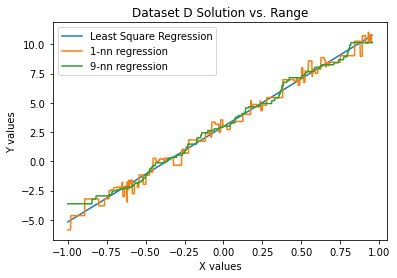

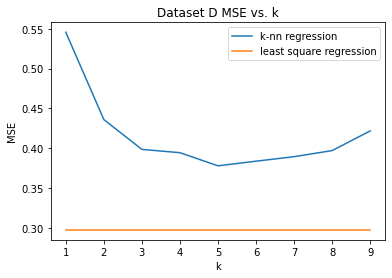

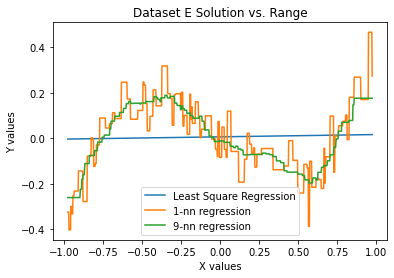

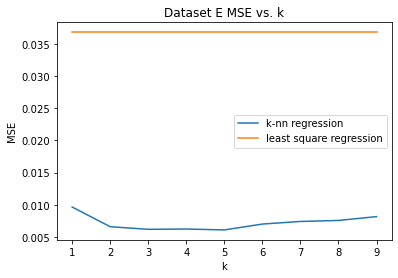

In [13]:
plt.figure(1)
plt.plot(D_X_range, D_train_lslr_y, label="Least Square Regression")
plt.plot(D_X_range, D_train_knn_y[0], label="1-nn regression")
plt.plot(D_X_range, D_train_knn_y[-1], label="9-nn regression")
plt.title("Dataset D Solution vs. Range")
plt.xlabel("X values")
plt.ylabel("Y values")
plt.legend()

plt.figure(2)
plt.plot(range(1,10), D_test_knn, label="k-nn regression")
plt.plot(range(1,10), D_test_lslr*np.ones(9), label="least square regression")
plt.title("Dataset D MSE vs. k")
plt.xlabel("k")
plt.ylabel("MSE")
plt.legend()


plt.figure(3)
plt.plot(E_X_range, E_train_lslr_y, label="Least Square Regression")
plt.plot(E_X_range, E_train_knn_y[0], label="1-nn regression")
plt.plot(E_X_range, E_train_knn_y[-1], label="9-nn regression")
plt.title("Dataset E Solution vs. Range")
plt.xlabel("X values")
plt.ylabel("Y values")
plt.legend()

plt.figure(4)
plt.plot(range(1,10), E_test_knn, label="k-nn regression")
plt.plot(range(1,10), E_test_lslr*np.ones(9), label="least square regression")
plt.title("Dataset E MSE vs. k")
plt.xlabel("k")
plt.ylabel("MSE")
plt.legend()

For dataset D, the k-nn regression is very close to the least square regression, and the test error is higher since the test example is probably more linear - closer to the least square regression, although both regressions have a fairly small test error. 

For dataset E, the k-nn regression and least square regression varies a lot, and the test example shows that the k-nn regression has less error and thus performs better than the least square regression.

Overall, k-nn regression performs better, and we also observe that when $k\in[3,5]$, the k-nn regression has least test errors and is closer to the test example. 

In [14]:
d = 20
F_train_X = pd.read_csv("datasets/X_train_F.csv", header=None).to_numpy()
F_train_y = pd.read_csv("ddtastts/Y_train_F.csv", header=None).to_numpy()
F_test_X = pd.read_csv("datasets/X_test_F.csv", header=None).to_numpy()
F_test_y = pd.read_csv("datasets/Y_test_F.csv", header=None).to_numpy()
n_f = len(F_train_X)

# Least Square Regression
f_w, f_b = lslr_solu(F_train_X, F_train_y)
f_w = f_w.transpose()
f_lslr_y = np.array([np.dot(f_w, x) + f_b for x in F_test_X])
f_lslr_err = LA.norm(f_lslr_y-F_test_y)**2 / len(F_test_y)

# k-nn regression
f_knn_y, f_knn_err, f_dist = [], [], []
for k in range(1,4):
    f, dist = [], []
    for x in F_test_X:
        res = knn(F_train_X, F_train_y, n_f, k, x, 1)
        f += [res[0]]
        dist += [res[1]]
    f_knn_err += [LA.norm(f-F_test_y.transpose())**2 / len(F_test_X)]
    f_knn_y += [f]
    f_dist += [dist]
f_dist = np.array([p[:,0] for p in f_dist[-1]])

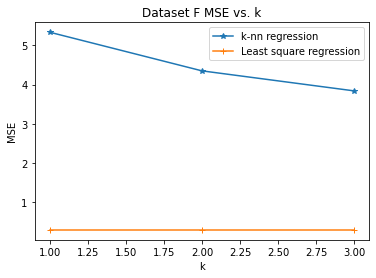

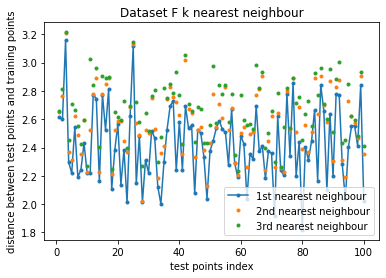

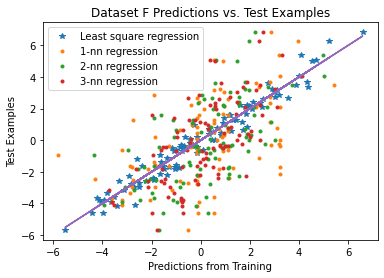

In [15]:
plt.figure(1)
plt.plot(range(1,4), f_knn_err, '*-', label="k-nn regression")
plt.plot(range(1,4), f_lslr_err*np.ones(3), '+-', label="Least square regression")
plt.title("Dataset F MSE vs. k")
plt.xlabel("k")
plt.ylabel("MSE")
plt.legend()

plt.figure(2)
plt.plot(range(1,len(F_test_X)+1), f_dist[:,0], '.-', label="1st nearest neighbour")
plt.plot(range(1,len(F_test_X)+1), f_dist[:,1], '.', label="2nd nearest neighbour")
plt.plot(range(1,len(F_test_X)+1), f_dist[:,2], '.', label="3rd nearest neighbour")
plt.title("Dataset F k nearest neighbour")
plt.xlabel("test points index")
plt.ylabel("distance between test points and training points")
plt.legend()

plt.figure(3)
plt.plot(f_lslr_y, F_test_y, '*', label="Least square regression")
for k in range(3):
    plt.plot(f_knn_y[k], F_test_y, '.', label=f"{k+1}-nn regression")
plt.plot(f_lslr_y, f_lslr_y, '-')
plt.title("Dataset F Predictions vs. Test Examples")
plt.xlabel("Predictions from Training")
plt.ylabel("Test Examples")
plt.legend()

The least square regression is a better prediction for dataset F, since it has less test error and the predictions are much closer to the test examples. This is because the points in the training set is further from the test points and thus using the corresponding average $y$ value to predict the test example could result in significant differences. Also, from our previous observation in part (2), we notice that $k\in[3,5]$ gives the best prediction, as we can see for this dataset, $k=3$ performs way better than $k=1$ looking at the third plot. If we increase the $k$ value, this could make the k-nn regression perform better.

[5.7556932  4.30891958 3.74033168 3.59575378 3.81145693 3.67420167
 3.60864035 3.57508392 3.71067259 3.90108311 4.00779602 4.05757825
 4.07120396 4.04223755 4.02369731 4.03084622 4.10894533 4.14924629
 4.14295141 4.14735332 4.16426477 4.16773658 4.14110255 4.09544458
 4.05474891 4.11402023 4.0935986  4.09452744 4.1224542  4.13607792]
The best k value is 8.
The test error when k is 8 is 4.007347368530502.


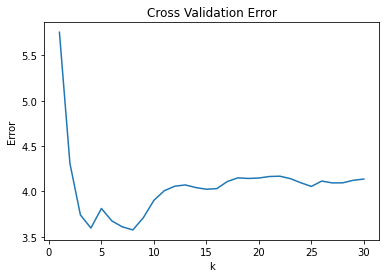

In [57]:
k_range = range(1,31)
F_train_split = np.split(np.array(range(n_f)), 10)
error = np.zeros(30)

# 10-fold cross validation
for j, k in enumerate(k_range):
    for l in range(10):
        train, train_y, test, test_y = np.array([]), np.array([]), np.array([]), np.array([])
        for i in range(10):
            if i != l:
                train = np.append(train, np.take(F_train_X, F_train_split[i], axis=0), axis=0) if len(train) != 0 else np.take(F_train_X, F_train_split[i], axis=0)
                train_y = np.append(train_y, np.take(F_train_y, F_train_split[i], axis=0), axis=0) if len(train_y) != 0 else np.take(F_train_y, F_train_split[i], axis=0)
            else:
                test = np.take(F_train_X, F_train_split[l], axis=0)
                test_y = np.take(F_train_y, F_train_split[l], axis=0)
        err = 0
        for i, t in enumerate(test):
            ans = knn(train, train_y, len(train), k, t)
            err += LA.norm(ans - test_y[i])**2
        error[j] += err / len(test)
    error[j] /= 10

plt.figure(1)
plt.plot(k_range, error)
plt.title("Cross Validation Error")
plt.xlabel("k")
plt.ylabel("Error")

best = min(error)
best_k = np.where(error == best)[0][0]+1
print(f"The best k value is {best_k}.")
err = np.array([])
res = np.array([])
for x in F_test_X:
    res = np.append(res, knn(F_train_X, F_train_y, n_f, best_k, x))
err = LA.norm(res-F_test_y.transpose())**2 / len(F_test_X)
print(f"The test error when k is {best_k} is {err}.")